# Trabajo Práctico 1: Reservas de Hotel

<hr width="50%" align="left"/>

<br/>

# Clasificación - Entrenamiento y Predicción
## **Checkpoint 3 - "Ensambles"**

<br/>

## **Grupo:** 03 - **_"Hackers Panas"_**

<br/>

## **Integrantes:**

<p>
<img align="left" src="https://github.com/NLGS2907.png" height=50 width=50 />

### [Franco Lighterman Reismann](https://github.com/NLGS2907) (106714)
<br/>
</p>

<p>
<img align="left" src="https://github.com/MarcosGN.png" height=50 width=50 />

### [Marcos García Neira](https://github.com/MarcosGN) (110363)
<br/>
</p>

<p>
<img align="left" src="https://github.com/mmaddalena.png" height=50 width=50 />

### [Martín Andrés Madalena](https://github.com/mmaddalena) (107610)
</p>

<br/><br/><br/><br/>
<hr/>

# **Instalaciones e _imports_ de librerías y otras dependencias.**

In [1]:
# Procesamiento de datos
import numpy as np
import pandas as pd

# Herramientas de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# sci-kit learn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (precision_score, recall_score, accuracy_score, f1_score, make_scorer,
                             confusion_matrix, classification_report, DistanceMetric)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

# Otras librerías de Machine-Learning
from xgboost import XGBClassifier

# type hinting
from typing import Any, Literal, Optional, TYPE_CHECKING, Union
if TYPE_CHECKING:
    from os import PathLike

# Otros
from IPython.display import display # preferible a print()
from pathlib import Path
from warnings import simplefilter
# from google.colab import drive # <- Sólo útil en la máquina del Colab

simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [2]:
# Va en una celda aparte para que no trate de montarlo cada vez que hay incluir nuevas librerías
# drive.mount('/content/drive')

<hr/>

# **Preprocesamiento de Datos**

Primero importamos los datasets:

In [3]:
# train = pd.read_csv("../Datasets/hotels_train.csv")
# tests = pd.read_csv("../Datasets/hotels_test.csv")
train = pd.read_csv("https://raw.githubusercontent.com/NLGS2907/7506R-2C2023-GRUPO03/master/TPs/TP1/Datasets/hotels_train.csv")
tests = pd.read_csv("https://raw.githubusercontent.com/NLGS2907/7506R-2C2023-GRUPO03/master/TPs/TP1/Datasets/hotels_test.csv")

In [4]:
# Variables de uso global
variables_categoricas = ["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel",
                         "is_repeated_guest", "reserved_room_type", "assigned_room_type", "deposit_type", "agent",
                         "company", "customer_type", "is_canceled"] # id no se deja a propósito
variables_cuantitativas = [categoria for categoria in train.columns if categoria not in variables_categoricas + ["id"]]

Y aplicamos, nuevamente, los tratamientos del Checkpoint 1 al dataset de entrenamiento, así como los escasos tratamientos de los datos de testeo del Checkpoint 2:

In [5]:
def tratamiento_train(df: pd.DataFrame,
                      *,
                      borrar_filas: bool=True,
                      borrar_columnas: bool=True,
                      imputaciones: bool=True) -> pd.DataFrame:
    """
    Realiza en forma rápida un resumen de todos los tratamientos explicados en el checkpoint 1
    a un DataFrame. Devuelve una copia sin afectar el original.
    -
    'borrar_filas': Si realizar los trabajos que borran filas o no.

    'borrar_columnas': Si realizar los trabajos que borran columnas o no.

    'imputaciones': Si realizar trabajos de imputaciones con el valor más frecuente.
    """

    df_copia = df.copy()

    # Eliminación de registros incompletos
    if borrar_columnas:
        df_copia = df_copia.drop(columns=["company"])

    if borrar_filas:
        df_copia = df_copia.dropna(axis="index", subset=["children", "country"])
    # ------------------------------ #

    # Imputación simple de datos
    if imputaciones:
        columnas_con_nulos = df.columns[df.isna().any()].tolist()
        imputador = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
        datos_imputados = imputador.fit_transform(df_copia)
        df_imp = pd.DataFrame(data=datos_imputados,
                            index=df_copia.index,
                            columns=df_copia.columns)
        for col in columnas_con_nulos:
            if col in df_copia.columns: # que no llore si ya fue borrado
                df_copia[col] = df_imp[col]
        df_copia.reset_index(drop=True) # para hacer coincidir de nuevo los números del índice
    # ------------------------------ #

    # Creación de columnas personalizadas
    if "people" not in df_copia.columns:
        df_copia.insert(11, "people", (df_copia["adults"] + df_copia["children"] + df_copia["babies"]).astype(int))
    # ------------------------------ #

    # Conversión a enteros de columnas pertinentes
    for categoria in ["children", "agent"]:
        df_copia[categoria] = df_copia[categoria].astype(int)
    # ------------------------------ #

    # Valores Atípicos
    if borrar_filas:
        if df_copia["adr"][df_copia["adr"] <= 0].count() != 0:
            df_copia.drop(df_copia[df_copia["adr"] <= 0].index, inplace=True)

        if df_copia["adults"][df_copia["adults"] == 0].count() != 0:
            df_copia.drop(df_copia[df_copia["adults"] == 0].index, inplace=True)

        if df_copia["people"][df_copia["people"] > 5].count() != 0:
            df_copia.drop(df_copia[df_copia["people"] > 5].index, inplace=True)

        if df_copia[(df_copia["is_repeated_guest"] == 0) &
                    (df_copia["previous_bookings_not_canceled"] != 0)].shape[0] != 0:
            df_copia.drop(df_copia[(df_copia["is_repeated_guest"] == 0) &
                                   (df_copia["previous_bookings_not_canceled"] != 0)].index, inplace=True)
    # ------------------------------ #

    return df_copia

In [6]:
def reducir_columnas(df_reductor: pd.DataFrame, df_a_reducir: pd.DataFrame) -> pd.DataFrame:
    """
    Quita todas las columnas de 'df_a_reducir' que no estén presentes en 'df_reductor'.
    """

    categorias = df_a_reducir.columns.to_list() # hacemos una copia de la lista para no mutar mientras recorremos
    df_reducido = df_a_reducir.copy()

    for categoria in categorias:
        if categoria not in df_reductor.columns:
            df_reducido.drop(categoria, axis="columns", inplace=True)

    return df_reducido

In [7]:
df_chp3 = tratamiento_train(train)
df_tests = reducir_columnas(df_chp3, tests)

<hr/>

# **Creación de _Splits_**

In [8]:
def get_df_dummies(df: pd.DataFrame,
                   *,
                   variables_indeseadas: tuple[str, ...]=("company", "id", "is_canceled"),
                   metodo: Literal["ohe", "pd"]="ohe"
) -> pd.DataFrame:
    """
    Consigue una versión con dummies de un Dataframe, con reglas personalizadas.
    -
    'df': El DataFrame sobre el cual trabajar.

    'variables_indeseadas': Variables categóricas, pero que igual no deberían tenerse en cuenta
                            para el cálculo.

    'metodo': El método para generar los dummies:
                - 'ohe' utiliza `sklearn.preprocessing.OneHotEncoder()`
                - 'pd' utiliza `pandas.get_dummies()`
    """

    if metodo not in ("ohe", "pd"):
        raise ValueError(f"Argumento metodo='{metodo}' no válido. Debe ser 'ohe' o 'pd'.")

    categorias = variables_categoricas.copy()
    for var in variables_indeseadas:
        if var in categorias:
            categorias.remove(var)

    if metodo == "ohe":
        ohe = OneHotEncoder(sparse_output=False, dtype=int).set_output(transform="pandas")
        return pd.concat([df.drop(categorias, axis="columns"), # df sólo con las cuantitativas
                          ohe.fit_transform(df[categorias])], # df con las cualitativas dummies
                         axis="columns")
    elif metodo == "pd":
        return pd.get_dummies(df, columns=categorias)

In [9]:
def split_in_axes(df: pd.DataFrame,
                  *,
                  x_innecesarias: tuple[str, ...]=("id", "is_canceled"),
                  target: Optional[str]=None
) -> pd.DataFrame:
    """
    Devuelve los ejes a entrenar/testear de un DataFrame.
    -
    'x_innecesarias': Qué columnas no incluir en el split del eje X.

    'target': La variable objetivo que terminará en el split del eje Y.
              El target también es eliminado, si se puede, del split del eje X.
    """

    if target is not None and target not in x_innecesarias:
        x_innecesarias.append(target)

    df_x = df.copy()
    for indeseada in x_innecesarias:
        if indeseada in df.columns:
            df_x = df_x.drop(indeseada, axis="columns", inplace=False)

    df_y = (None if target is None else df[target].copy())

    return df_x, df_y

Una función para optimizar hiperparámetros mediante _Cross Validation_:

In [10]:
def buscar_por_cv(*,
                  metodo: Literal["random", "grid"]="grid",
                  clasificador,
                  params_cv: dict[str, Any],
                  puntaje: Literal["accuracy", "recall", "precision", "f1"]="f1",

                  rand_comb: int=10,
                  folds: int=10,
                  kfold_estratificado: bool=True,
                  seed: Optional[int]=None) -> Union[RandomizedSearchCV, GridSearchCV]:
    """
    Realiza cross validation con parámetros dados.
    -
    'metodo': Con qué metodo realizar el trabajo:
              - 'random' es para utilizar `sklearn.model_selection.RandomizedSearchCV`
              - 'grid' es para utilizar `sklearn.model_selection.GridSearchCV`

    'clasificador': Un objeto estimador, ya inicializado: un árbol de decisión,
                    un clasificador KNN, etc.

    'params_cv': El diccionario de parámetros a probar en cada intento. Se asume que son compatibles
                 con el clasificador pasado.

    'puntaje': Método de puntaje:
               - 'accuracy' utiliza el Accuracy Score.
               - 'recall' utiliza el Recall Score.
               - 'precision' utiliza el Precision Score.
               - 'f1' utiliza el F1-Score.

    'rand_comb': Cantidad de combinaciones a probar si se elige el método 'random'.

    'folds': Cantidad de folds a usar en el KFold.

    'kfold_estratificado': Si utilizar `sklearn.model_selection.StratifiedKFold` o
                           `sklearn.model_selection.KFold`.

    'seed': La semilla para resultados determinísticos. Se usa sólo en el `RandomSearchCV()`.
            Si se desea una semilla para el clasificador, debe incluirse en 'params_cv'.
    """

    if metodo not in ("random", "grid"):
        raise ValueError(f"Argumento metodo='{metodo}' no válido. Debe ser 'random' o 'grid'.")

    if puntaje not in ("accuracy", "recall", "precision", "f1"):
        raise ValueError(f"Argumento puntaje={puntaje} no válido, debe de ser 'accuracy', "
                         f"'recall', 'precision' o 'f1'.")

    # Kfold estratificado
    if kfold_estratificado:
        kfoldcv = StratifiedKFold(n_splits=folds)
    else:
        kfoldcv = KFold(n_splits=folds)

    # metricas
    posibles_metricas = {
        "accuracy": accuracy_score,
        "recall": recall_score,
        "precision": precision_score,
        "f1": f1_score
    }
    scorer_fn = make_scorer(posibles_metricas[puntaje])

    if metodo == "random": # Random Search Cross Validation
        return RandomizedSearchCV(estimator=clasificador,
                                  param_distributions=params_cv,
                                  scoring=scorer_fn,
                                  cv=kfoldcv,
                                  n_iter=rand_comb,
                                  n_jobs=-1,
                                  random_state=seed)

    if metodo == "grid": # Grid Search Cross Validation
        return GridSearchCV(estimator=clasificador,
                            param_grid=params_cv,
                            scoring=scorer_fn,
                            cv=kfoldcv,
                            n_jobs=-1,
                            return_train_score=True)

Y una función extra para mostrar las evaluaciones:

In [11]:
def evaluar(y_test: np.ndarray,
            y_pred: np.ndarray,
            *,
            seed_splits: Optional[int]=None,
            seed_modelo: Optional[int]=None,
            porcentaje_test: Optional[float]=None,
            mostrar_matriz: bool=True,
            titulo_matriz: Optional[str]=None) -> None:
    """
    Muestra los resultados de la performance en distintas métricas
    y además también la matriz de confunsión.
    -
    'y_test': La colección de datos a testear.

    'y_pred': La colección de predicciones a comparar con los datos de 'y_test'.

    'seed_splits'/'seed_modelo': Las semillas de generación pseudo-aleatoria para los splits
                                 train/tests y para el clasificador respectivamente.

    'porcentaje_test': Un float de `0.0` a `1.0`. Usado para calcular los splits de train/test.

    'mostrar_matriz': Si mostrar o no la matriz de confusión.

    'titulo_matriz': Si se dibuja la matriz, el título que aparecerá.
    """

    meta_info = []

    if seed_splits is not None:
        meta_info.append(f"Splits Seed:\t{seed_splits}")

    if seed_modelo is not None:
        meta_info.append(f"Model Seed:\t\t{seed_modelo}")

    if porcentaje_test is not None:
        meta_info.append(f"Train/Test:\t\t{100 - (porcentaje_test * 100)}% / "
                         f"{porcentaje_test * 100}%")

    if meta_info:
        meta_str = "\n".join(meta_info)
        print(f"{meta_str}\n-")

    print(f"Accuracy:\t\t{accuracy_score(y_test, y_pred)}\n"
          f"Recall:\t\t\t{recall_score(y_test, y_pred)}\n"
          f"Precision:\t\t{precision_score(y_test, y_pred)}\n"
          f"f1 score:\t\t{f1_score(y_test, y_pred)}\n\n")

    print(classification_report(y_test, y_pred))

    if mostrar_matriz:
        matriz_conf = confusion_matrix(y_test, y_pred)

        ax = sns.heatmap(matriz_conf, cmap="GnBu", annot=True, fmt="g")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

        plt.title((titulo_matriz if titulo_matriz is not None else "Matriz de Confusión"))
        plt.show()

<hr width="30%" align="left" />

In [12]:
train_dummies = get_df_dummies(df_chp3)
train_dummies_x, train_dummies_y = split_in_axes(train_dummies, target="is_canceled")

semilla = 3
porcentaje_test = 0.2

sc = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(train_dummies_x,
                                                    train_dummies_y,
                                                    test_size=porcentaje_test,
                                                    stratify=train_dummies_y, # Acá en el Checkpoint 3 ya es importante estratificar
                                                    random_state=semilla)

x_train_norm = sc.fit_transform(x_train)
x_test_norm = sc.transform(x_test)

<hr/>

# **Creación de Modelos**

Es acá que efectivamente creamos cada modelo, las métricas de puntaje, tal cual explicadas en el Checkpoint 2, son las siguientes:

* **Accuracy:** La cantidad de **positivos y negativos predichos correctamente**, sobre el total de todos los datos. $\frac{TP + TN}{TP + TN + FP + FN}$
* **Recall:** La cantidad de **positivos predichos correctamente**, sobre todos los que _deberían ser positivos_ (los positivos correctamente predichos más los negativos mal predichos). $\frac{TP}{TP + FN}$
* **Precision:** La cantidad de **positivos predichos correctamente**, sobre todos los positivos (tanto los correctos como los mal predichos). $\frac{TP}{TP + FP}$
* **F1 Score:** Esta métrica se calcula con la media armónica de _Recall_ y _Precision_, por lo que ayuda a representar a ambas en una sola métrica. $\frac{2 \times Precision \times Recall}{Precision + Recall}$

<hr width="30%" align="left" />

## **Clasificador _K-Nearest Neighbors_**

Algunas de los parámetros a considerar para el KNN:

* **n_neighbors:** El número de vecinos a considerar.

* **weights:** El peso relativo de cada vecino:
    - _uniform:_ Cada vecino tiene el mismo peso independientemente de su distancia al centro elegido.
    - _distance:_ Cada vecino tiene un peso asignado que es inversamente proporcional a la distancia del centro elegido.

* **metric:** La forma de calcular la "distancia" entre los vecinos y el "centro" de la posición de un dato nuevo:
    - _euclidean_ / _l2_: Es la que respeta la geometría euclideana; utiliza el camino más corto entre dos puntos.
    - _manhattan_ / _cityblock_ / _l1_: Suma la distancia de cada eje, en vez del camino más corto. Útil cuando los puntos están distribuidos en una especie de cuadrícula.

In [13]:
# # ----- Buscado por CV -----
# parametros_cv_knn = {
#     "n_neighbors": np.arange(5, 30),
#     "weights": ["distance"],
#     "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
#     "metric": ["manhattan", "euclidean", "cosine", "haversine"]
# }
# cv_knn = buscar_por_cv(metodo="random",
#                        clasificador=KNeighborsClassifier(),
#                        params_cv=parametros_cv_knn,
#                        puntaje="f1",
#                        rand_comb=20,
#                        folds=10,
#                        kfold_estratificado=True,
#                        seed=semilla)
# cv_knn.fit(X=x_train, y=y_train)

# print(f"{cv_knn.best_params_}\n"
#       f"{cv_knn.best_score_}")
# knn = cv_knn.best_estimator_
# # --------------------------

# ----- Creado Manualmente -----
knn = KNeighborsClassifier(n_neighbors=25,
                           weights="distance",
                           algorithm="auto",
                           metric="manhattan")
knn.fit(X=x_train,
        y=y_train)
# ------------------------------

KNeighborsClassifier(metric='manhattan', n_neighbors=25, weights='distance')

In [14]:
y_pred_knn = knn.predict(x_test)

Splits Seed:	3
Train/Test:		80.0% / 20.0%
-
Accuracy:		0.7805341933349872
Recall:			0.8164030653839882
Precision:		0.7661820964039786
f1 score:		0.7904957372908115


              precision    recall  f1-score   support

           0       0.80      0.74      0.77      5960
           1       0.77      0.82      0.79      6133

    accuracy                           0.78     12093
   macro avg       0.78      0.78      0.78     12093
weighted avg       0.78      0.78      0.78     12093



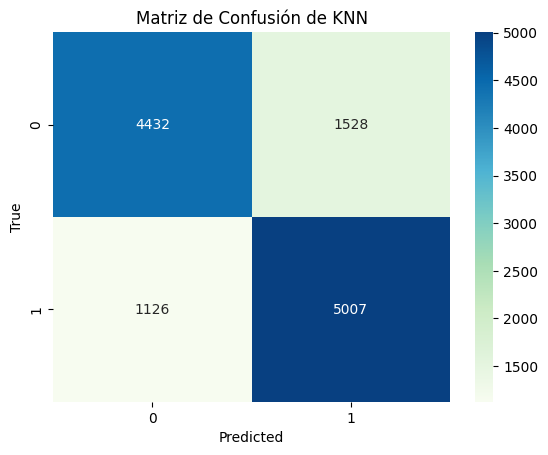

In [15]:
evaluar(y_test, y_pred_knn,
        seed_splits=semilla,
        porcentaje_test=porcentaje_test,
        titulo_matriz="Matriz de Confusión de KNN")

<hr width="30%" align="left" />

## **Clasificador _Support Vector Machine_**

Parámetros para el SVM varían entre:

* **kernel:** La función núclero (_kernel_) con la que trata de "separar" el conjunto de datos en dos, elevando las observaciones a una dimensión mayor.
    - _linear:_ Utiliza una función "lineal". Sólo funciona cuando el problema es linealmente separable.
    - _poly:_ Utiliza una función polinómica; _i.e._ algo del siguiente estilo:
$X^n + \text{coef0}$

* **coef0:** El coeficiente independiente; se utiliza en todas las funciones _kernel_ donde sea posible.

In [16]:
semilla_svm = 1

# # ----- Buscado por CV -----
# parametros_cv_svm = {
#     "kernel": ["linear", "poly", "rbf", "sigmoid"],
#     "gamma": ["auto", "scale"],
#     "coef0": np.linspace(0.0, 5.0, 20),
#     "probability": [True],
#     "random_state": [semilla_svm]
# }
# cv_svm = buscar_por_cv(metodo="random",
#                        clasificador=SVC(),
#                        params_cv=parametros_cv_svm,
#                        puntaje="f1",
#                        rand_comb=5,
#                        folds=12,
#                        kfold_estratificado=True,
#                        seed=semilla)
# cv_svm.fit(X=x_train_norm, y=y_train)

# print(f"{cv_svm.best_params_}\n"
#       f"{cv_svm.best_score_}")
# svm = cv_svm.best_estimator_
# # --------------------------

# ----- Creado Manualmente -----
svm = SVC(kernel="poly",
          coef0=8.5,
        #   probability=True,
        #   random_state=semilla_svm
)

svm.fit(X=x_train_norm,
        y=y_train)
# ------------------------------

SVC(coef0=8.5, kernel='poly')

In [17]:
y_pred_svm = svm.predict(x_test_norm)

Splits Seed:	3
Model Seed:		1
Train/Test:		80.0% / 20.0%
-
Accuracy:		0.8516497147109898
Recall:			0.8601010924506767
Precision:		0.849299629689261
f1 score:		0.8546662346079066


              precision    recall  f1-score   support

           0       0.85      0.84      0.85      5960
           1       0.85      0.86      0.85      6133

    accuracy                           0.85     12093
   macro avg       0.85      0.85      0.85     12093
weighted avg       0.85      0.85      0.85     12093



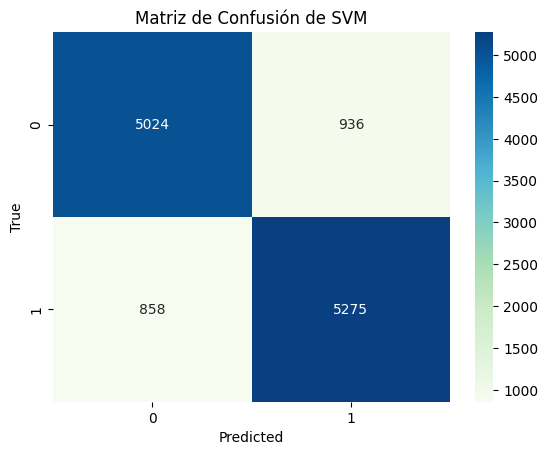

In [18]:
evaluar(y_test, y_pred_svm,
        seed_splits=semilla,
        seed_modelo=semilla_svm,
        porcentaje_test=porcentaje_test,
        titulo_matriz="Matriz de Confusión de SVM")

<hr width="30%" align="left" />

## **Clasificador _Random Forest_**

Algunos parámetros para el RF son compartidos con los árboles de decisión, pues son similares en naturaleza:

* **criterion:** El criterio con el que decidir cómo dividir y qué nodos:
    - _gini:_ Utiliza la impureza de Gini.
    - _entropy:_ Utiliza el cálculo de entropía.

* **min_samples_leaf:** La cantidad mínima de muestras que una hoja debe tener para ser considerada tal.

* **min_samples_splits:** La cantidad mínima de muestras que un nodo debe tener como para considerar dividirlo.

Además, este clasificador cuenta con parámetros propios:

* **n_estimators:** Cuántos árboles utilizar en la clasificación.

In [20]:
semilla_rf = 1

# # ----- Buscado por CV -----
# parametros_cv_rf = {
#     "criterion" : ["gini", "entropy"],
#     "min_samples_leaf" : [1, 3, 5, 10],
#     "min_samples_split" : [2, 3, 4, 5, 6, 10, 12],
#     "n_estimators": [10, 20, 50, 70, 100],

#     # para compatibilidad con la búsqueda manual
#     "max_features": ["auto"],
#     "oob_score": [True],
#     "random_state": [semilla_rf],
#     "n_jobs": [-1]
# }

# cv_rf = buscar_por_cv(metodo="grid",
#                       clasificador=RandomForestClassifier(),
#                       params_cv=parametros_cv_rf,
#                       puntaje="f1",
#                       folds=5,
#                       kfold_estratificado=True,
#                       seed=semilla)
# cv_rf.fit(X=x_train, y=y_train)

# print(f"{cv_rf.best_params_}\n"
#       f"{cv_rf.best_score_}")
# rfc = cv_rf.best_estimator_
# # --------------------------

# ----- Creado Manualmente -----
rfc = RandomForestClassifier(max_features=None,
                             oob_score=True,
                             random_state=semilla_rf,
                             n_jobs=-1,
                             criterion="entropy",
                             min_samples_leaf=1,
                             min_samples_split=3,
                             n_estimators=100)

rfc.fit(X=x_train,
        y=y_train)
# ------------------------------

RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_split=3, n_jobs=-1, oob_score=True,
                       random_state=1)

In [21]:
y_pred_rf = rfc.predict(x_test)

Splits Seed:	3
Train/Test:		80.0% / 20.0%
-
Accuracy:		0.8812536177954189
Recall:			0.886515571498451
Precision:		0.8802007446980735
f1 score:		0.8833468724614134


              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5960
           1       0.88      0.89      0.88      6133

    accuracy                           0.88     12093
   macro avg       0.88      0.88      0.88     12093
weighted avg       0.88      0.88      0.88     12093



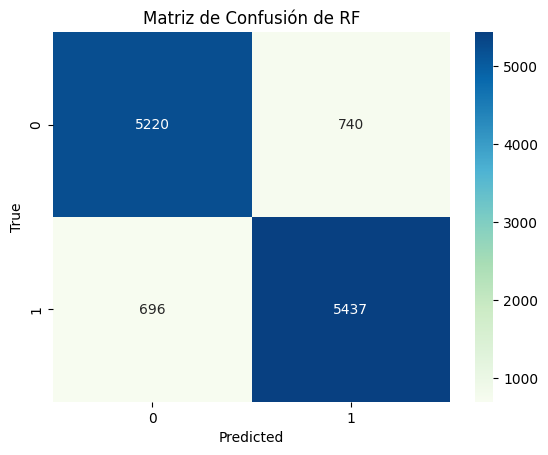

In [22]:
evaluar(y_test, y_pred_rf,
        seed_splits=semilla,
        porcentaje_test=porcentaje_test,
        titulo_matriz="Matriz de Confusión de RF")

<hr width="30%" align="left" />

## **Clasificador _XGBoost_**

Los parámetros de este clasificador son muchos y variados; esto quizás porque no necesariamente viene de la biblioteca de _scikit-learn,_ aunque sí implementa sus interfaces, por lo que podemos optimizar sus hiper-parámetros con _cross validation_ como siempre.
Ejemplos de dichos parámetros son:

* **n_estimators:** Cuántos árboles utilizar en la clasificación.

* **max_depth:** Profundidad máxima que utilizar en cada árbol. _(A diferencia de por ejemplo el AdaBoost, acá los árboles pueden tener más profundidad)_

* **max_leaves:** Cantidad de hojas máxima por árbol.

* **learning_rate:** El coeficiente con el que ir suavizando los datos para no hacer _overfitting_.

In [23]:
semilla_xgb = 1

# # ----- Buscado por CV -----
# parametros_cv_xgb = {
#     "n_estimators": np.arange(50, 151),
#     "max_depth": np.arange(0, 20),
#     "max_leaves": np.arange(0, 30),
#     "gamma": np.linspace(0.0, 15, 50),
#     "reg_alpha": np.linspace(0.0, 5, 20),
#     "reg_lambda": np.linspace(0.0, 5, 20),
#     "learning_rate": np.linspace(0.0, 0.8, 50),
#     "n_jobs": [-1],
#     "random_state": [semilla_xgb]
# }
# cv_xgb = buscar_por_cv(metodo="random",
#                        clasificador=XGBClassifier(),
#                        params_cv=parametros_cv_xgb,
#                        puntaje="f1",
#                        rand_comb=150,
#                        folds=10,
#                        kfold_estratificado=True,
#                        seed=semilla)
# cv_xgb.fit(X=x_train, y=y_train)

# print(f"{cv_xgb.best_params_}\n"
#       f"{cv_xgb.best_score_}")
# xgb = cv_xgb.best_estimator_
# # --------------------------

# ----- Creado Manualmente -----
xgb = XGBClassifier(random_state=semilla_xgb,
                    n_jobs=-1,
                    n_estimators=72,
                    max_leaves=0,
                    max_depth=19,
                    learning_rate=0.2285714285714286,
                    reg_lambda=1.3157894736842104,
                    gamma=3.673469387755102,
                    reg_alpha=1.0526315789473684)

xgb.fit(x_train,
        y_train)
# ------------------------------

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.673469387755102, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2285714285714286,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=19, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=72, n_jobs=-1,
              num_parallel_tree=None, random_state=1, ...)

In [24]:
y_pred_xgb = xgb.predict(x_test)

Splits Seed:	3
Model Seed:		1
Train/Test:		80.0% / 20.0%
-
Accuracy:		0.8778632266600512
Recall:			0.8845589434208381
Precision:		0.8758475944462383
f1 score:		0.8801817149346962


              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5960
           1       0.88      0.88      0.88      6133

    accuracy                           0.88     12093
   macro avg       0.88      0.88      0.88     12093
weighted avg       0.88      0.88      0.88     12093



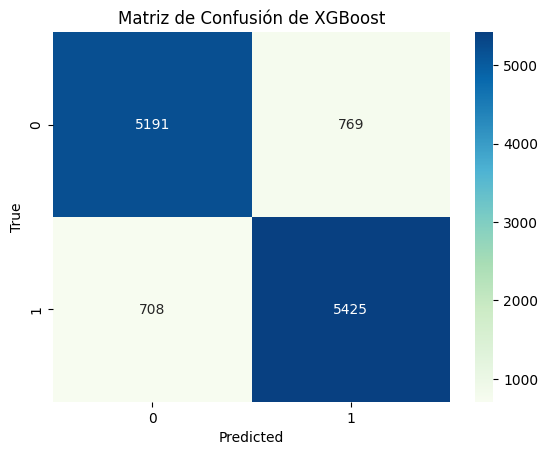

In [25]:
evaluar(y_test, y_pred_xgb,
        seed_splits=semilla,
        seed_modelo=semilla_xgb,
        porcentaje_test=porcentaje_test,
        titulo_matriz="Matriz de Confusión de XGBoost")

<hr width="30%" align="left" />

## **Ensambles Híbridos**

Usamos para apilar los modelos creados anteriormente, pues son los más optimizados. Utilizamos por temas de rendimiento RF y XGB, que son los que menos tardan en calcularse y además, los de mayor puntaje.

In [26]:
modelos_base = [
    # ("knn", knn),
    # ("svm", svm),
    ("rf", rfc),
    ("xgb", xgb)
]

<hr width="20%" align="left" />

### **Ensamble tipo _Voting_**

Este ensamble agarra todos los modelos y trata de predecir con los votos de la mayoría.
Los parámetros básicos son:

* **estimators:** Todos los clasificadores a utilizar.

* **voting:** La estrategia de voto:
    - _hard:_ Elige el valor dado por mayoría estricta.
    - _soft:_ Pondera con cálculos como el promedio, etc.

In [27]:
voting = VotingClassifier(estimators=modelos_base,
                          voting="soft",
                          n_jobs=-1)
voting.fit(X=x_train,
           y=y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_features=None,
                                                     min_samples_split=3,
                                                     n_jobs=-1, oob_score=True,
                                                     random_state=1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=Fa...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2285714285714286,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=19,
                                            max_leaves=0, min_child_weight=None,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=72, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=1, ...))],
                 n_jobs=-1, voting='soft')

In [28]:
y_pred_voting = voting.predict(x_test)

Splits Seed:	3
Train/Test:		80.0% / 20.0%
-
Accuracy:		0.8829901595964608
Recall:			0.8879830425566607
Precision:		0.8820861678004536
f1 score:		0.8850247826440237


              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5960
           1       0.88      0.89      0.89      6133

    accuracy                           0.88     12093
   macro avg       0.88      0.88      0.88     12093
weighted avg       0.88      0.88      0.88     12093



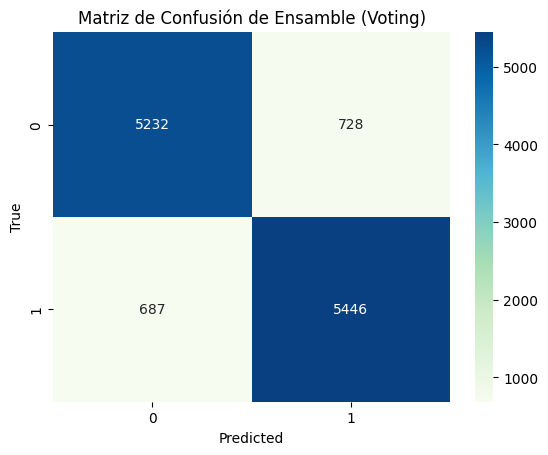

In [29]:
evaluar(y_test, y_pred_voting,
        seed_splits=semilla,
        porcentaje_test=porcentaje_test,
        titulo_matriz="Matriz de Confusión de Ensamble (Voting)")

<hr width="20%" align="left" />

### **Ensamble tipo _Stacking_**

Este ensamble utiliza un "meta-modelo" para decidir qué modelo utilizar al predecir según la ocasión. Algunos parámetros son:

* **estimators:** Todos los clasificadores a utilizar.

* **final_estimator:** El "meta-modelo" que decide qué modelo de **estimators** utilizar.

* **passtrough:** Si el meta-modelo se entrena también con los datos de entrenamiento, y no sólo las predicciones hechas.

Primero definimos el modelo que decide cuál modelo utilizar:

In [30]:
meta_modelo = LogisticRegressionCV()

In [31]:
stacking = StackingClassifier(estimators=modelos_base,
                              final_estimator=meta_modelo,
                              passthrough=True,
                              cv=KFold(n_splits=5),
                              n_jobs=-1,
                              verbose=2)
stacking.fit(X=x_train,
             y=y_train)

StackingClassifier(cv=KFold(n_splits=5, random_state=RandomState(MT19937) at 0x1FB91244F40,
   shuffle=False),
                   estimators=[('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_features=None,
                                                       min_samples_split=3,
                                                       n_jobs=-1,
                                                       oob_score=True,
                                                       random_state=1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=N...
                                              learning_rate=0.2285714285714286,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=19,
                                              max_leaves=0,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=72, n_jobs=-1,
                                              num_parallel_tree=None,
                                              random_state=1, ...))],
                   final_estimator=LogisticRegressionCV(), n_jobs=-1,
                   passthrough=True, verbose=2)

In [32]:
y_pred_stacking = stacking.predict(x_test)

Splits Seed:	3
Train/Test:		80.0% / 20.0%
-
Accuracy:		0.8840651616637725
Recall:			0.8839067340616338
Precision:		0.8870888561610211
f1 score:		0.8854949362953283


              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5960
           1       0.89      0.88      0.89      6133

    accuracy                           0.88     12093
   macro avg       0.88      0.88      0.88     12093
weighted avg       0.88      0.88      0.88     12093



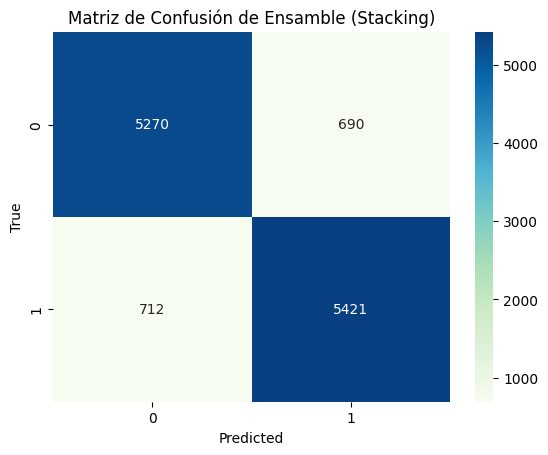

In [33]:
evaluar(y_test, y_pred_stacking,
        seed_splits=semilla,
        porcentaje_test=porcentaje_test,
        titulo_matriz="Matriz de Confusión de Ensamble (Stacking)")

<hr/>

# **Exportando Predicciones**

In [34]:
def alinear_df_test(df_train: pd.DataFrame, df_test: pd.DataFrame,
                    *,
                    vacio: Union[int, float]=0
) -> pd.DataFrame:
    """
    Esta función hace dos cosas:
        - Crea toda columna presente en 'df_train' (pero no en 'df_test') como una columna nueva
          en 'df_test' y las rellena con el valor 'vacio'.
        - Elimina toda columna que esté en 'df_test' pero no en 'df_train'.

    Se presupone que ambos DataFrames vienen sólo con valores numéricos; normalmente fueron
    convertidos a DataFrames con dummies.
    -
    'df_train': El DataFrame con el que se entrenó el modelo.

    'df_test': El DataFrame con los datos a predecir.

    'vacio': El valor con el que rellenar las columnas insertadas en 'df_test'. Normalmente es `0`,
             pues es el valor que se usa en One Hot Encoding para designar que NO es esa variable.
    """

    df_test_convertida = reducir_columnas(df_train, df_test)

    for col in df_train.columns:
        if col not in df_test.columns:
            nueva_col = np.array([0] * df_test.shape[0]).reshape(-1, 1)
            df_test_convertida[col] = nueva_col

    return df_test_convertida[df_train.columns] # reordenar las columnas con el mismo orden

In [35]:
def generar_predicciones(train_dummies: pd.DataFrame, df_test: pd.DataFrame,
                         *,
                         modelo,
                         normalizar_splits: bool=False,
                         escalador: Literal["std", "minmax"]="std") -> np.ndarray:
    """
    Toma un dataset de entrenamiento pertinente, y el dataset de testeo, y genera las predicciones
    para ese modelo.
    -
    'train_dummies': El dataset de entrenamiento, ya con sus dummies.

    'df_test': El dataset de testeo.

    'modelo': El modelo de predicción, ya entrenado.

    'normalizar_splits': Los splits, donde sea posible, serán normalizados con un escalador.

    'escalador': El escalador con el que normalizar los splits:
                 - 'std' utiliza `sklearn.preprocessing.StandardScaler`.
                 - 'minmax' utiliza `sklearn.preprocessing.MinMaxScaler`.
    """

    if escalador not in ("std", "minmax"):
        raise ValueError(f"Argumento escalador='{escalador}' no válido. Debe ser 'std' o 'minmax'.")

    tests_dummies_desalineados = get_df_dummies(df_test).rename(columns=(lambda col : (col.removesuffix(".0") if col.endswith(".0") else col)))

    test_dummies = alinear_df_test(train_dummies, tests_dummies_desalineados)
    test_x, _ = split_in_axes(test_dummies)

    if normalizar_splits:
        if escalador == "std":
            scaler = StandardScaler()
        elif escalador == "minmax":
            scaler = MinMaxScaler()

        x_a_predecir = scaler.fit_transform(test_x)

    else:
        x_a_predecir = test_x

    return modelo.predict(x_a_predecir)

In [36]:
def exportar_predicciones(df_test: pd.DataFrame, predicciones: np.ndarray,
                          *,
                          target: str="is_canceled",
                          nombre: "PathLike", # Más bien que se parezca a un nombre de archivo con extensión
                          ruta: "PathLike"="./drive/MyDrive/Colab Notebooks/predictions") -> None:
    """
    Intenta guardar las predicciones en una ruta en Google Drive, para uso interno. Normalmente
    como forma temporal para después subirlo a kaggle.
    Se presupone que el drive ya fue montado junto con los imports.
    -
    'df_test': El DataFrame de los datos a predecir. De acá sacamos la columna 'id'.

    'predicciones': Un `numpy.ndarray` (o lo que salga de `model.predict()`). Estos son los valores
                    que han de llenar la columna del target.

    'target': El nombre de la columna del target. A efectos de este TP1 siempre debería
              ser `"is_canceled"`.

    'nombre': El nombre del archivo en cuestión, de formato `.csv`. Ejemplo: `"predicted1.csv"`.

    'ruta': Ruta del directorio en Drive donde el archivo será guardado.
    """

    path = Path(ruta) / nombre
    df_a_exportar = pd.DataFrame()

    df_a_exportar["id"] = df_test["id"]
    df_a_exportar[target] = predicciones.reshape(-1, 1)

    df_a_exportar.to_csv(path, index=False)